In [1]:
%reload_ext autotime
import pandas as pd
import requests
import geopandas as gpd
from tqdm.auto import tqdm
from tqdm.contrib.concurrent import process_map
import time
import os
from glob import glob
from coastsat import SDS_transects
import json
import matplotlib.pyplot as plt
import dotenv
dotenv.load_dotenv()

True

In [2]:
poly = gpd.read_file("polygons.geojson")
poly = poly[poly.id.str.startswith("nzd")]
poly.set_index("id", inplace=True)
poly

area id_sorted      northing  \
id                                              
nzd0001  3.069093e+06   nzd0001 -4.085604e+06   
nzd0002  1.507931e+06   nzd0002 -4.086100e+06   
nzd0003  2.484730e+06   nzd0003 -4.087232e+06   
nzd0006  9.619509e+05   nzd0004 -4.090732e+06   
nzd0007  3.109433e+06   nzd0005 -4.095516e+06   
...               ...       ...           ...   
nzd0313  2.291974e+07   nzd0558 -4.939929e+06   
nzd0314  3.124363e+07   nzd0559 -4.943102e+06   
nzd0561  8.710035e+05   nzd0560 -5.905869e+06   
nzd0562           NaN      None           NaN   
nzd0563           NaN      None           NaN   

                                                  geometry  
id                                                          
nzd0001  POLYGON ((172.96406 -34.43054, 172.99324 -34.4...  
nzd0002  POLYGON ((172.93456 -34.42857, 172.95856 -34.4...  
nzd0003  POLYGON ((173.0098 -34.42055, 173.00088 -34.44...  
nzd0006  POLYGON ((173.00532 -34.46694, 173.00612 -34.4...  
nzd0007  POLYGON ((172.99847 -34.48102, 173.00081 -34.5...  
...                                                    ...  
nzd0313  POLYGON ((172.89281 -40.50518, 172.73306 -40.5...  
nzd0314  POLYGON ((173.04122 -40.54521, 172.89309 -40.5...  
nzd0561  POLYGON ((168.53017 -46.77383, 168.52 -46.7786...  
nzd0562  POLYGON ((174.90844 -36.8799, 174.90844 -36.86...  
nzd0563  POLYGON ((176.9378 -39.33472, 176.93374 -39.33...  

[562 rows x 4 columns]

1999-08-17 22:10:00+00:00 POINT (172.97690966086745 -34.42150701355086)


<Axes: xlabel='time'>

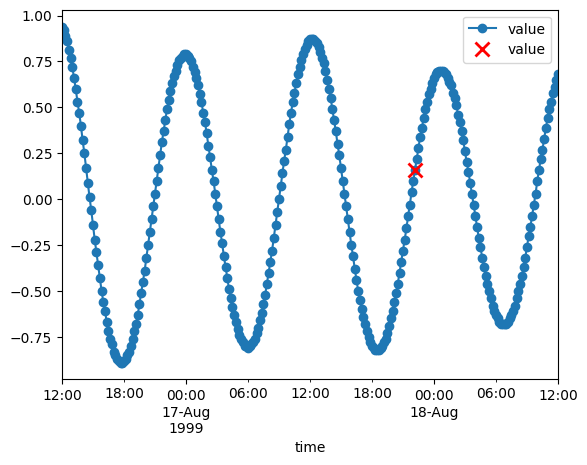

In [3]:
sitename = "nzd0001"
dates = pd.to_datetime(pd.read_csv(f"data/{sitename}/transect_time_series.csv").dates).dt.round("10min")
point = poly.geometry[sitename].centroid
datetime = dates.iloc[0]
print(datetime, point)
r = requests.get("https://api.niwa.co.nz/tides/data", params={
    "lat": point.y,
    "long": point.x,
    "numberOfDays": 2,
    "startDate": str(datetime.date()),
    "datum": "MSL",
    "interval": 10, # 10 minute resolution
    "apikey": os.environ["NIWA_API_KEY"]
}, timeout=(30,30))
df = pd.DataFrame(r.json()["values"])
df.index = pd.to_datetime(df.time)
ax = df.plot(style="o-")
df[df.index == datetime].plot(color="red", style="x", ax=ax, mew=2, ms=10)

In [4]:
datetime, datetime.tz_convert("Pacific/Auckland")

(Timestamp('1999-08-17 22:10:00+0000', tz='UTC'),
 Timestamp('1999-08-18 10:10:00+1200', tz='Pacific/Auckland'))

When I asked for 1 day (1999-08-17), I got 1999-08-16 12:00 - 1999-08-17 12:00. Have to request 2 days, then pull out the one datetime I want

In [5]:
files = pd.DataFrame({"filename": sorted(glob("data/nzd*/transect_time_series.csv"))})
files["sitename"] = files.filename.str.split("/").str[1]
files["have_tides"] = files.sitename.apply(lambda s: os.path.isfile(f"data/{s}/tides.csv"))
files

filename sitename  have_tides
0    data/nzd0001/transect_time_series.csv  nzd0001        True
1    data/nzd0002/transect_time_series.csv  nzd0002        True
2    data/nzd0003/transect_time_series.csv  nzd0003        True
3    data/nzd0004/transect_time_series.csv  nzd0004        True
4    data/nzd0005/transect_time_series.csv  nzd0005        True
..                                     ...      ...         ...
557  data/nzd0559/transect_time_series.csv  nzd0559        True
558  data/nzd0560/transect_time_series.csv  nzd0560        True
559  data/nzd0561/transect_time_series.csv  nzd0561        True
560  data/nzd0562/transect_time_series.csv  nzd0562        True
561  data/nzd0563/transect_time_series.csv  nzd0563        True

[562 rows x 3 columns]

In [6]:
def get_tide_for_dt(point, datetime):
    while True:
        try:
            r = requests.get("https://api.niwa.co.nz/tides/data", params={
                "lat": point.y,
                "long": point.x,
                "numberOfDays": 2,
                "startDate": str(datetime.date()),
                "datum": "MSL",
                "interval": 10, # 10 minute resolution
                "apikey": os.environ["NIWA_API_KEY"]
            }, timeout=(30,30))
        except Exception as e:
            print(e)
            time.sleep(5)
            continue
        if r.status_code == 200:
            df = pd.DataFrame(r.json()["values"])
            df.index = pd.to_datetime(df.time)
            return df.value[datetime]
        elif r.status_code == 429:
            sleep_seconds = 30
            # sleep for x seconds to refresh the count
            print(f'Num of API reqs exceeded, Sleeping for: {sleep_seconds} seconds...')
            time.sleep(sleep_seconds)

for sitename in tqdm(files[~files.have_tides].sitename):
    dates = pd.to_datetime(pd.read_csv(f"data/{sitename}/transect_time_series.csv").dates).dt.round("10min")
    point = poly.geometry[sitename].centroid

    results = []
    for date in tqdm(dates):
        result = get_tide_for_dt(point, date)
        results.append({
            "dates": date,
            "tide": result
        })
    df = pd.DataFrame(results)
    df.set_index("dates", inplace=True)
    df.to_csv(f"data/{sitename}/tides.csv")

0it [00:00, ?it/s]

In [7]:
files["have_tides"] = files.sitename.apply(lambda s: os.path.isfile(f"data/{s}/tides.csv"))

In [8]:
# Transects, origin is landward. Has beach_slope
transects = gpd.read_file("transects_extended.geojson").to_crs(2193).drop_duplicates(subset="id")
transects.set_index("id", inplace=True)
transects

site_id  orientation  along_dist  along_dist_norm  beach_slope  \
id                                                                             
aus0001-0000  aus0001   104.347648    0.000000         0.000000        0.085   
aus0001-0001  aus0001    93.495734   98.408334         0.002935        0.050   
aus0001-0002  aus0001    82.069341  198.408334         0.005918        0.050   
aus0001-0003  aus0001    81.192757  298.402523         0.008900        0.055   
aus0001-0004  aus0001    81.065473  398.402523         0.011882        0.075   
...               ...          ...         ...              ...          ...   
ber0002-0009  ber0002          NaN         NaN              NaN        0.080   
ber0002-0010  ber0002          NaN         NaN              NaN        0.085   
ber0002-0011  ber0002          NaN         NaN              NaN        0.105   
ber0002-0012  ber0002          NaN         NaN              NaN        0.105   
ber0002-0013  ber0002          NaN         NaN              NaN        0.055   

                 cil     ciu     trend  n_points  n_points_nonan  r2_score  \
id                                                                           
aus0001-0000  0.0545  0.2000 -1.441081     767.0           428.0  0.168420   
aus0001-0001  0.0387  0.0640 -1.037105     767.0           569.0  0.097874   
aus0001-0002  0.0428  0.0647 -0.680019     767.0           588.0  0.053927   
aus0001-0003  0.0480  0.0659 -0.405198     767.0           598.0  0.023412   
aus0001-0004  0.0614  0.0922 -0.090025     767.0           608.0  0.001277   
...              ...     ...       ...       ...             ...       ...   
ber0002-0009  0.0638  0.1065  0.088578     223.0           192.0  0.006440   
ber0002-0010  0.0673  0.1096  0.028300     223.0           190.0  0.000497   
ber0002-0011  0.0797  0.1462  0.057356     223.0           187.0  0.002423   
ber0002-0012  0.0835  0.1428 -0.010553     223.0           186.0  0.000081   
ber0002-0013  0.0491  0.0674  0.157248     223.0           177.0  0.014649   

                    mae          mse       rmse   intercept ERODIBILITY  \
id                                                                        
aus0001-0000  28.102591  1263.560863  35.546601  179.085729        None   
aus0001-0001  25.419324  1033.770813  32.152306  212.247788        None   
aus0001-0002  22.632907   838.007507  28.948359  205.106151        None   
aus0001-0003  20.749758   698.653187  26.432048  191.745881        None   
aus0001-0004  19.889328   655.810616  25.608800  175.092121        None   
...                 ...          ...        ...         ...         ...   
ber0002-0009   6.645872    70.165869   8.376507  128.134846        None   
ber0002-0010   7.682399    92.744157   9.630377  128.837353        None   
ber0002-0011   7.512558    79.234887   8.901398  129.482491        None   
ber0002-0012   7.210548    79.289497   8.904465  131.010602        None   
ber0002-0013   7.547493    95.120607   9.752979  136.403294        None   

                                                       geometry  
id                                                               
aus0001-0000  LINESTRING (-422245.836 7118667.88, -421827.54...  
aus0001-0001  LINESTRING (-422256.313 7118525.222, -421837.6...  
aus0001-0002  LINESTRING (-422219.773 7118383.012, -421816.8...  
aus0001-0003  LINESTRING (-422187.543 7118279.615, -421786.5...  
aus0001-0004  LINESTRING (-422155.665 7118178.983, -421754.9...  
...                                                         ...  
ber0002-0009  LINESTRING (7337061.509 24464210.895, 7337094....  
ber0002-0010  LINESTRING (7336972.269 24464234.663, 7337116....  
ber0002-0011  LINESTRING (7336938.536 24464246.657, 7337082....  
ber0002-0012  LINESTRING (7336855.021 24464292.3, 7337104.78...  
ber0002-0013  LINESTRING (7336825.968 24464313.049, 7337075....  

[147194 rows x 17 columns]

In [9]:
def despike(chainage, threshold=40):
    chainage = chainage.dropna()
    chainage, dates = SDS_transects.identify_outliers(chainage.tolist(), chainage.index.tolist(), threshold)
    return pd.Series(chainage, index=dates)

def process_sitename(sitename):
    transects_at_site = transects[transects.site_id == sitename]
    assert len(transects_at_site)
    raw_intersects = pd.read_csv(f"data/{sitename}/transect_time_series.csv")#.drop(columns=["Unnamed: 0"])
    sat_times = pd.to_datetime(raw_intersects.dates).dt.round("10min")
    raw_intersects.set_index("dates", inplace=True)
    raw_intersects.index = pd.to_datetime(raw_intersects.index)
    tides = pd.read_csv(f"data/{sitename}/tides.csv")
    tides.set_index("dates", inplace=True)
    tides.index = pd.to_datetime(tides.index)
    tides = tides[tides.index.isin(sat_times)]
    if not all(sat_times.isin(tides.index)):
        dates = sat_times[~sat_times.isin(tides.index)]
        print(f"Fetching missing tides for {len(dates)} dates at {sitename}")
        point = poly.geometry[sitename].centroid
        results = []
        for date in tqdm(dates):
            result = get_tide_for_dt(point, date)
            results.append({
                "dates": date,
                "tide": result
            })
        new_tides = pd.DataFrame(results)
        new_tides.dates = pd.to_datetime(new_tides.dates)
        new_tides.set_index("dates", inplace=True)
        tides = pd.concat([tides, new_tides])
        tides.sort_index(inplace=True)
        tides.to_csv(f"data/{sitename}/tides.csv")
    corrections = tides.tide.apply(lambda tide: tide / transects_at_site.beach_slope.interpolate().bfill().ffill()).set_index(raw_intersects.index)
    corrections.columns = corrections.columns.astype(str)
    tidally_corrected = raw_intersects + corrections
    tidally_corrected = tidally_corrected.drop(columns="satname").apply(despike, axis=0)
    tidally_corrected.index.name = "dates"
    if len(tidally_corrected) == 0:
        print(f"Despike removed all points for {sitename}")
    tidally_corrected["satname"] = raw_intersects.satname
    tidally_corrected.to_csv(f"data/{sitename}/transect_time_series_tidally_corrected.csv")
    return tidally_corrected

_ = process_map(process_sitename, files.sitename)
#process_sitename("nzd0562")

Fetching missing tides for 2 dates at nzd0023

Fetching missing tides for 1 dates at nzd0002

Fetching missing tides for 5 dates at nzd0024

Fetching missing tides for 1 dates at nzd0003

Fetching missing tides for 2 dates at nzd0028

  0%|          | 0/562 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0001

Fetching missing tides for 2 dates at nzd0005

Fetching missing tides for 2 dates at nzd0015

Fetching missing tides for 1 dates at nzd0010

Fetching missing tides for 1 dates at nzd0006

Fetching missing tides for 2 dates at nzd0016

Fetching missing tides for 2 dates at nzd0029

Fetching missing tides for 2 dates at nzd0020

Fetching missing tides for 1 dates at nzd0004

Fetching missing tides for 2 dates at nzd0014

Fetching missing tides for 1 dates at nzd0012

Fetching missing tides for 1 dates at nzd0019

Fetching missing tides for 2 dates at nzd0030

Fetching missing tides for 1 dates at nzd0022

Fetching missing tides for 1 dates at nzd0017

Fetching missing tides for 2 dates at nzd0011

Fetching missing tides for 2 dates at nzd0013

Fetching missing tides for 2 dates at nzd0021

Fetching missing tides for 3 dates at nzd0027

Fetching missing tides for 5 dates at nzd0032

Fetching missing tides for 2 dates at nzd0018

Fetching missing tides for 4 dates at nzd0026

Fetching missing tides for 3 dates at nzd0025

Fetching missing tides for 2 dates at nzd0031

  0%|          | 0/2 [00:00<?, ?it/s]

Fetching missing tides for 2 dates at nzd0009

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

*

Fetching missing tides for 2 dates at nzd0033

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 6 dates at nzd0034

*

  0%|          | 0/6 [00:00<?, ?it/s]

Fetching missing tides for 6 dates at nzd0035

  0%|          | 0/6 [00:00<?, ?it/s]

Fetching missing tides for 5 dates at nzd0036

  0%|          | 0/5 [00:00<?, ?it/s]

Fetching missing tides for 4 dates at nzd0037

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

Fetching missing tides for 4 dates at nzd0038

  0%|          | 0/4 [00:00<?, ?it/s]

Fetching missing tides for 5 dates at nzd0039

  0%|          | 0/5 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0041

*

Fetching missing tides for 4 dates at nzd0040

Fetching missing tides for 5 dates at nzd0043

*

Fetching missing tides for 4 dates at nzd0042

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Fetching missing tides for 2 dates at nzd0044

  0%|          | 0/2 [00:00<?, ?it/s]

Fetching missing tides for 4 dates at nzd0045

  0%|          | 0/4 [00:00<?, ?it/s]

Fetching missing tides for 2 dates at nzd0046

Fetching missing tides for 5 dates at nzd0047

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

*

Fetching missing tides for 5 dates at nzd0048

  0%|          | 0/5 [00:00<?, ?it/s]

Fetching missing tides for 4 dates at nzd0050

Fetching missing tides for 3 dates at nzd0008

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Fetching missing tides for 5 dates at nzd0049

  0%|          | 0/5 [00:00<?, ?it/s]

Fetching missing tides for 4 dates at nzd0052

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

Fetching missing tides for 5 dates at nzd0053

  0%|          | 0/5 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0054

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 6 dates at nzd0055

*

  0%|          | 0/6 [00:00<?, ?it/s]

Fetching missing tides for 2 dates at nzd0056

  0%|          | 0/2 [00:00<?, ?it/s]

Fetching missing tides for 2 dates at nzd0057

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0058

  0%|          | 0/2 [00:00<?, ?it/s]

Fetching missing tides for 2 dates at nzd0059

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0060

  0%|          | 0/2 [00:00<?, ?it/s]

Fetching missing tides for 2 dates at nzd0061

  0%|          | 0/2 [00:00<?, ?it/s]

Fetching missing tides for 2 dates at nzd0063

  0%|          | 0/2 [00:00<?, ?it/s]

Fetching missing tides for 2 dates at nzd0064

  0%|          | 0/2 [00:00<?, ?it/s]

Fetching missing tides for 2 dates at nzd0065

  0%|          | 0/2 [00:00<?, ?it/s]

Fetching missing tides for 3 dates at nzd0066

  0%|          | 0/3 [00:00<?, ?it/s]

Fetching missing tides for 2 dates at nzd0068

Fetching missing tides for 2 dates at nzd0067

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Fetching missing tides for 4 dates at nzd0069

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 2 dates at nzd0070

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0071

Fetching missing tides for 5 dates at nzd0051

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

*

Fetching missing tides for 3 dates at nzd0072

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

Fetching missing tides for 2 dates at nzd0073

  0%|          | 0/2 [00:00<?, ?it/s]

Fetching missing tides for 3 dates at nzd0074

  0%|          | 0/3 [00:00<?, ?it/s]

*

Fetching missing tides for 3 dates at nzd0075

*

  0%|          | 0/3 [00:00<?, ?it/s]

Fetching missing tides for 3 dates at nzd0076

  0%|          | 0/3 [00:00<?, ?it/s]

*

Fetching missing tides for 3 dates at nzd0077

*

  0%|          | 0/3 [00:00<?, ?it/s]

*

Fetching missing tides for 3 dates at nzd0078

  0%|          | 0/3 [00:00<?, ?it/s]

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 3 dates at nzd0079

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 3 dates at nzd0080

Num of API reqs exceeded, Sleeping for: 30 seconds...

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 3 dates at nzd0081

  0%|          | 0/3 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Fetching missing tides for 3 dates at nzd0082

  0%|          | 0/3 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 2 dates at nzd0083

  0%|          | 0/2 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 2 dates at nzd0084

  0%|          | 0/2 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

Fetching missing tides for 2 dates at nzd0085

Num of API reqs exceeded, Sleeping for: 30 seconds...

  0%|          | 0/2 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Fetching missing tides for 2 dates at nzd0086

*

  0%|          | 0/2 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 2 dates at nzd0087

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 2 dates at nzd0088

Num of API reqs exceeded, Sleeping for: 30 seconds...

  0%|          | 0/2 [00:00<?, ?it/s]

*

Fetching missing tides for 2 dates at nzd0089

  0%|          | 0/2 [00:00<?, ?it/s]

Fetching missing tides for 2 dates at nzd0090

  0%|          | 0/2 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 3 dates at nzd0091

  0%|          | 0/3 [00:00<?, ?it/s]

Fetching missing tides for 2 dates at nzd0092

  0%|          | 0/2 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 2 dates at nzd0093

Num of API reqs exceeded, Sleeping for: 30 seconds...

  0%|          | 0/2 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 2 dates at nzd0094

Num of API reqs exceeded, Sleeping for: 30 seconds...

  0%|          | 0/2 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 2 dates at nzd0095

  0%|          | 0/2 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0096

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 3 dates at nzd0097

  0%|          | 0/3 [00:00<?, ?it/s]

Fetching missing tides for 4 dates at nzd0098

  0%|          | 0/4 [00:00<?, ?it/s]

Fetching missing tides for 4 dates at nzd0099

  0%|          | 0/4 [00:00<?, ?it/s]

Fetching missing tides for 3 dates at nzd0100

  0%|          | 0/3 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0101

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0103

*

*

*

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

Fetching missing tides for 2 dates at nzd0105

*

Fetching missing tides for 3 dates at nzd0104

Fetching missing tides for 3 dates at nzd0106

  0%|          | 0/2 [00:00<?, ?it/s]

*

Fetching missing tides for 3 dates at nzd0102

  0%|          | 0/3 [00:00<?, ?it/s]

Fetching missing tides for 3 dates at nzd0107

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0108

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0109

*

  0%|          | 0/3 [00:00<?, ?it/s]

*

Fetching missing tides for 3 dates at nzd0110

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

Fetching missing tides for 4 dates at nzd0112

*

  0%|          | 0/4 [00:00<?, ?it/s]

Fetching missing tides for 5 dates at nzd0113

*

  0%|          | 0/5 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0115

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0116

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

Fetching missing tides for 1 dates at nzd0117

*

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0118

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 4 dates at nzd0119

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0120

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

Fetching missing tides for 1 dates at nzd0121

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 1 dates at nzd0122

*

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

Fetching missing tides for 4 dates at nzd0123

*

*

*

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 4 dates at nzd0124

*

  0%|          | 0/4 [00:00<?, ?it/s]

Fetching missing tides for 4 dates at nzd0125

*

*

*

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

Fetching missing tides for 1 dates at nzd0126

Fetching missing tides for 3 dates at nzd0128

Fetching missing tides for 4 dates at nzd0127

*

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 4 dates at nzd0129

*

*

*

*

*

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0130

*

*

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0131

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

Fetching missing tides for 1 dates at nzd0132

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0133

*

*

*

*

*

*

*

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 3 dates at nzd0134

*

Fetching missing tides for 3 dates at nzd0135

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

*

*

*

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 4 dates at nzd0138

*

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 3 dates at nzd0139

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

Fetching missing tides for 3 dates at nzd0140

*

*

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 4 dates at nzd0141

*

*

Fetching missing tides for 3 dates at nzd0142

*

*

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 5 dates at nzd0143

*

*

  0%|          | 0/5 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 5 dates at nzd0144

*

*

*

*

*

*

*

  0%|          | 0/5 [00:00<?, ?it/s]

*

*

*

*

Fetching missing tides for 4 dates at nzd0111

*

*

*

*

*

*

*

*

*

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

*

*

*

Fetching missing tides for 4 dates at nzd0137

*

*

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 5 dates at nzd0145

*

*

  0%|          | 0/5 [00:00<?, ?it/s]

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

Fetching missing tides for 5 dates at nzd0146

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

  0%|          | 0/5 [00:00<?, ?it/s]

*

*

*

*

Fetching missing tides for 5 dates at nzd0147

*

*

*

*

*

*

*

  0%|          | 0/5 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 4 dates at nzd0148

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

  0%|          | 0/4 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0150

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 4 dates at nzd0151

*

*

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

Fetching missing tides for 2 dates at nzd0152

Fetching missing tides for 2 dates at nzd0153

*

*

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0154

*

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0157

*

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0158

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Fetching missing tides for 2 dates at nzd0159

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

Fetching missing tides for 3 dates at nzd0156

Fetching missing tides for 4 dates at nzd0155

*

Fetching missing tides for 4 dates at nzd0149

Fetching missing tides for 2 dates at nzd0160

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

Fetching missing tides for 3 dates at nzd0161

*

*

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0162

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Fetching missing tides for 2 dates at nzd0163

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0164

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0165

  0%|          | 0/3 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Fetching missing tides for 4 dates at nzd0167

*

  0%|          | 0/4 [00:00<?, ?it/s]

Fetching missing tides for 3 dates at nzd0168

  0%|          | 0/3 [00:00<?, ?it/s]

Fetching missing tides for 4 dates at nzd0169

  0%|          | 0/4 [00:00<?, ?it/s]

Fetching missing tides for 3 dates at nzd0170

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

*

*

*

Fetching missing tides for 6 dates at nzd0171

  0%|          | 0/6 [00:00<?, ?it/s]

*

Fetching missing tides for 3 dates at nzd0166

  0%|          | 0/3 [00:00<?, ?it/s]

*

Fetching missing tides for 3 dates at nzd0173

*

Fetching missing tides for 3 dates at nzd0172

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

Fetching missing tides for 4 dates at nzd0174

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

Fetching missing tides for 3 dates at nzd0175

  0%|          | 0/3 [00:00<?, ?it/s]

Fetching missing tides for 2 dates at nzd0176

  0%|          | 0/2 [00:00<?, ?it/s]

Fetching missing tides for 2 dates at nzd0177

  0%|          | 0/2 [00:00<?, ?it/s]

Fetching missing tides for 2 dates at nzd0178

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0180

  0%|          | 0/3 [00:00<?, ?it/s]

Fetching missing tides for 3 dates at nzd0179

Fetching missing tides for 2 dates at nzd0181

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Fetching missing tides for 3 dates at nzd0182

  0%|          | 0/3 [00:00<?, ?it/s]

Fetching missing tides for 2 dates at nzd0183

  0%|          | 0/2 [00:00<?, ?it/s]

Fetching missing tides for 3 dates at nzd0184

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

Fetching missing tides for 3 dates at nzd0187

Fetching missing tides for 5 dates at nzd0186

Fetching missing tides for 5 dates at nzd0185

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

*

Fetching missing tides for 4 dates at nzd0188

  0%|          | 0/4 [00:00<?, ?it/s]

Fetching missing tides for 4 dates at nzd0189

Fetching missing tides for 4 dates at nzd0190

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Fetching missing tides for 5 dates at nzd0191

  0%|          | 0/5 [00:00<?, ?it/s]

*

*

Fetching missing tides for 5 dates at nzd0192

*

  0%|          | 0/5 [00:00<?, ?it/s]

*

Fetching missing tides for 6 dates at nzd0193

*

Fetching missing tides for 5 dates at nzd0195

  0%|          | 0/6 [00:00<?, ?it/s]

*

Fetching missing tides for 6 dates at nzd0194

  0%|          | 0/5 [00:00<?, ?it/s]

*

  0%|          | 0/6 [00:00<?, ?it/s]

Fetching missing tides for 5 dates at nzd0196

  0%|          | 0/5 [00:00<?, ?it/s]

Fetching missing tides for 5 dates at nzd0197

  0%|          | 0/5 [00:00<?, ?it/s]

*

Fetching missing tides for 5 dates at nzd0198

  0%|          | 0/5 [00:00<?, ?it/s]

*

Fetching missing tides for 5 dates at nzd0199

  0%|          | 0/5 [00:00<?, ?it/s]

Fetching missing tides for 5 dates at nzd0200

  0%|          | 0/5 [00:00<?, ?it/s]

Fetching missing tides for 5 dates at nzd0201

Fetching missing tides for 2 dates at nzd0202

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

*

Fetching missing tides for 6 dates at nzd0203

  0%|          | 0/6 [00:00<?, ?it/s]

Fetching missing tides for 4 dates at nzd0204

  0%|          | 0/4 [00:00<?, ?it/s]

Fetching missing tides for 2 dates at nzd0205

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0206

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 5 dates at nzd0207

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

  0%|          | 0/5 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

Fetching missing tides for 2 dates at nzd0209

  0%|          | 0/2 [00:00<?, ?it/s]

*

Fetching missing tides for 3 dates at nzd0208

Fetching missing tides for 3 dates at nzd0210

  0%|          | 0/3 [00:00<?, ?it/s]

*

  0%|          | 0/3 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

Fetching missing tides for 2 dates at nzd0211

  0%|          | 0/2 [00:00<?, ?it/s]

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 4 dates at nzd0212

  0%|          | 0/4 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 6 dates at nzd0213

Num of API reqs exceeded, Sleeping for: 30 seconds...

  0%|          | 0/6 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

Fetching missing tides for 6 dates at nzd0214

Fetching missing tides for 2 dates at nzd0215

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0216

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 4 dates at nzd0217

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 2 dates at nzd0218

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0221

Fetching missing tides for 6 dates at nzd0219

Fetching missing tides for 2 dates at nzd0220

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

  0%|          | 0/6 [00:00<?, ?it/s]

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

Fetching missing tides for 2 dates at nzd0222

*

  0%|          | 0/2 [00:00<?, ?it/s]

Fetching missing tides for 2 dates at nzd0223

*

Fetching missing tides for 1 dates at nzd0224

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0225

*

  0%|          | 0/2 [00:00<?, ?it/s]

Fetching missing tides for 2 dates at nzd0226

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 5 dates at nzd0227

Fetching missing tides for 1 dates at nzd0228

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0229

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

Fetching missing tides for 5 dates at nzd0230

*

  0%|          | 0/5 [00:00<?, ?it/s]

Fetching missing tides for 2 dates at nzd0231

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0232

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 5 dates at nzd0233

*

  0%|          | 0/5 [00:00<?, ?it/s]

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0234

*

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0235

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

Fetching missing tides for 5 dates at nzd0236

*

  0%|          | 0/5 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0237

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 4 dates at nzd0238

*

Fetching missing tides for 3 dates at nzd0239

  0%|          | 0/4 [00:00<?, ?it/s]

*

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 5 dates at nzd0240

  0%|          | 0/5 [00:00<?, ?it/s]

*

Fetching missing tides for 2 dates at nzd0241

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0242

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

Fetching missing tides for 2 dates at nzd0243

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0244

*

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0245

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

Fetching missing tides for 4 dates at nzd0246

*

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0247

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

Fetching missing tides for 3 dates at nzd0248

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

Fetching missing tides for 2 dates at nzd0249

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

Fetching missing tides for 4 dates at nzd0250

*

*

*

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0251

*

*

*

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Fetching missing tides for 2 dates at nzd0252

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0253

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0254

*

  0%|          | 0/1 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0255

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0256

Fetching missing tides for 3 dates at nzd0257

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

*

Fetching missing tides for 3 dates at nzd0258

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

*

Fetching missing tides for 4 dates at nzd0259

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

  0%|          | 0/4 [00:00<?, ?it/s]

Fetching missing tides for 3 dates at nzd0260

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0262

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 2 dates at nzd0261

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

Fetching missing tides for 1 dates at nzd0263

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0264

Num of API reqs exceeded, Sleeping for: 30 seconds...

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0265

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

Fetching missing tides for 3 dates at nzd0266

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0267

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 1 dates at nzd0268

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 2 dates at nzd0269

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 2 dates at nzd0270

  0%|          | 0/2 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0271

  0%|          | 0/1 [00:00<?, ?it/s]

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0272

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0273

  0%|          | 0/3 [00:00<?, ?it/s]

Fetching missing tides for 3 dates at nzd0274

  0%|          | 0/3 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

Fetching missing tides for 2 dates at nzd0275

  0%|          | 0/2 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0276

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0277

  0%|          | 0/3 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 6 dates at nzd0278

  0%|          | 0/6 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0279

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0280

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0281

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0282

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0283

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0284

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

Fetching missing tides for 1 dates at nzd0285

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0286

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0287

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0288

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0289

*

*

  0%|          | 0/3 [00:00<?, ?it/s]

*

Fetching missing tides for 1 dates at nzd0290

*

*

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0291

*

*

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

*

*

Fetching missing tides for 4 dates at nzd0292

*

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0293

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0294

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0295

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

Fetching missing tides for 1 dates at nzd0296

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0297

*

Fetching missing tides for 1 dates at nzd0298

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0299

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 4 dates at nzd0300

*

*

*

*

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 4 dates at nzd0301

*

*

*

*

*

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0304

Fetching missing tides for 1 dates at nzd0305

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0306

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 4 dates at nzd0303

Fetching missing tides for 1 dates at nzd0302

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0308

*

*

Fetching missing tides for 2 dates at nzd0314

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 3 dates at nzd0316

Fetching missing tides for 6 dates at nzd0317

  0%|          | 0/2 [00:00<?, ?it/s]

Fetching missing tides for 4 dates at nzd0315

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Fetching missing tides for 4 dates at nzd0309

Fetching missing tides for 3 dates at nzd0311

*

  0%|          | 0/4 [00:00<?, ?it/s]

Fetching missing tides for 5 dates at nzd0318

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Fetching missing tides for 4 dates at nzd0307

Fetching missing tides for 5 dates at nzd0319

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 6 dates at nzd0320

  0%|          | 0/6 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0321

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

Fetching missing tides for 6 dates at nzd0322

  0%|          | 0/6 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

Fetching missing tides for 5 dates at nzd0323

*

  0%|          | 0/5 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0324

*

Fetching missing tides for 2 dates at nzd0325

  0%|          | 0/1 [00:00<?, ?it/s]

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0313

*

  0%|          | 0/3 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0326

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0327

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 5 dates at nzd0328

*

*

  0%|          | 0/5 [00:00<?, ?it/s]

Fetching missing tides for 6 dates at nzd0329

  0%|          | 0/6 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0331

Fetching missing tides for 1 dates at nzd0330

*

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 2 dates at nzd0332

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

Fetching missing tides for 6 dates at nzd0333

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

  0%|          | 0/6 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 2 dates at nzd0334

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 6 dates at nzd0335

*

  0%|          | 0/6 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 4 dates at nzd0336

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

Fetching missing tides for 6 dates at nzd0337

  0%|          | 0/6 [00:00<?, ?it/s]

Fetching missing tides for 3 dates at nzd0338

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

Fetching missing tides for 6 dates at nzd0339

*

  0%|          | 0/6 [00:00<?, ?it/s]

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 6 dates at nzd0340

*

*

  0%|          | 0/6 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0341

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0342

*

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0343

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0344

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

Fetching missing tides for 6 dates at nzd0345

*

  0%|          | 0/6 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 3 dates at nzd0346

*

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0347

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0348

Fetching missing tides for 1 dates at nzd0349

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0350

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

Fetching missing tides for 6 dates at nzd0351

*

  0%|          | 0/6 [00:00<?, ?it/s]

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0352

*

  0%|          | 0/3 [00:00<?, ?it/s]

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0353

  0%|          | 0/1 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 3 dates at nzd0354

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Fetching missing tides for 3 dates at nzd0355

  0%|          | 0/3 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 5 dates at nzd0356

  0%|          | 0/5 [00:00<?, ?it/s]

Fetching missing tides for 3 dates at nzd0357

  0%|          | 0/3 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0358

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 5 dates at nzd0359

  0%|          | 0/5 [00:00<?, ?it/s]

Fetching missing tides for 3 dates at nzd0360

  0%|          | 0/3 [00:00<?, ?it/s]

Fetching missing tides for 5 dates at nzd0361

  0%|          | 0/5 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0362

*

  0%|          | 0/3 [00:00<?, ?it/s]

*

Fetching missing tides for 6 dates at nzd0363

  0%|          | 0/6 [00:00<?, ?it/s]

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0364

*

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

*

*

Fetching missing tides for 4 dates at nzd0365

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

*

*

*

*

Fetching missing tides for 6 dates at nzd0366

  0%|          | 0/6 [00:00<?, ?it/s]

*

*

*

*

*

Fetching missing tides for 6 dates at nzd0367

  0%|          | 0/6 [00:00<?, ?it/s]

Fetching missing tides for 5 dates at nzd0368

  0%|          | 0/5 [00:00<?, ?it/s]

Fetching missing tides for 5 dates at nzd0369

  0%|          | 0/5 [00:00<?, ?it/s]

*

*

*

*

*

Fetching missing tides for 6 dates at nzd0370

  0%|          | 0/6 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 6 dates at nzd0371

  0%|          | 0/6 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 5 dates at nzd0372

  0%|          | 0/5 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0373

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0374

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 3 dates at nzd0375

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

Fetching missing tides for 5 dates at nzd0376

  0%|          | 0/5 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0377

Fetching missing tides for 2 dates at nzd0378

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

Fetching missing tides for 4 dates at nzd0380

Fetching missing tides for 7 dates at nzd0379

  0%|          | 0/4 [00:00<?, ?it/s]

*

  0%|          | 0/7 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0381

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0382

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 4 dates at nzd0383

  0%|          | 0/4 [00:00<?, ?it/s]

Fetching missing tides for 3 dates at nzd0384

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

*

*

*

Fetching missing tides for 6 dates at nzd0385

  0%|          | 0/6 [00:00<?, ?it/s]

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0386

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

Fetching missing tides for 2 dates at nzd0387

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

Fetching missing tides for 5 dates at nzd0388

  0%|          | 0/5 [00:00<?, ?it/s]

*

*

*

*

Fetching missing tides for 6 dates at nzd0389

  0%|          | 0/6 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0390

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0391

  0%|          | 0/2 [00:00<?, ?it/s]

*

Fetching missing tides for 6 dates at nzd0392

  0%|          | 0/6 [00:00<?, ?it/s]

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

Fetching missing tides for 1 dates at nzd0393

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

  0%|          | 0/1 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

Fetching missing tides for 1 dates at nzd0394

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

Fetching missing tides for 6 dates at nzd0395

  0%|          | 0/6 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0396

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 2 dates at nzd0397

  0%|          | 0/2 [00:00<?, ?it/s]

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 4 dates at nzd0398

  0%|          | 0/4 [00:00<?, ?it/s]

Fetching missing tides for 2 dates at nzd0399

  0%|          | 0/2 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 4 dates at nzd0400

  0%|          | 0/4 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 1 dates at nzd0401

  0%|          | 0/1 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 1 dates at nzd0402

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0403

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 4 dates at nzd0404

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0405

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0406

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0407

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0408

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 4 dates at nzd0409

  0%|          | 0/4 [00:00<?, ?it/s]

Fetching missing tides for 2 dates at nzd0410

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0411

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0412

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0413

  0%|          | 0/3 [00:00<?, ?it/s]

Fetching missing tides for 3 dates at nzd0414

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0415

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 3 dates at nzd0416

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

Fetching missing tides for 3 dates at nzd0417

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0418

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0419

  0%|          | 0/3 [00:00<?, ?it/s]

*

Fetching missing tides for 3 dates at nzd0420

  0%|          | 0/3 [00:00<?, ?it/s]

Fetching missing tides for 3 dates at nzd0421

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 3 dates at nzd0422

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 4 dates at nzd0423

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 4 dates at nzd0425

*

Fetching missing tides for 3 dates at nzd0424

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0426

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 2 dates at nzd0427

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0428

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 2 dates at nzd0429

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0430

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 4 dates at nzd0431

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

Fetching missing tides for 4 dates at nzd0432

Fetching missing tides for 4 dates at nzd0433

*

*

*

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 4 dates at nzd0435

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

*

*

*

*

Fetching missing tides for 5 dates at nzd0436

*

  0%|          | 0/5 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0437

*

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

*

*

*

Fetching missing tides for 5 dates at nzd0438

*

*

*

*

*

  0%|          | 0/5 [00:00<?, ?it/s]

*

*

*

*

*

Fetching missing tides for 5 dates at nzd0439

*

*

*

*

*

*

  0%|          | 0/5 [00:00<?, ?it/s]

*

*

Fetching missing tides for 5 dates at nzd0440

*

*

*

  0%|          | 0/5 [00:00<?, ?it/s]

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0441

  0%|          | 0/3 [00:00<?, ?it/s]

Fetching missing tides for 3 dates at nzd0442

*

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0443

  0%|          | 0/3 [00:00<?, ?it/s]

Fetching missing tides for 3 dates at nzd0444

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0447

*

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

Fetching missing tides for 4 dates at nzd0448

  0%|          | 0/4 [00:00<?, ?it/s]

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Fetching missing tides for 4 dates at nzd0450

  0%|          | 0/4 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

Fetching missing tides for 4 dates at nzd0451

*

  0%|          | 0/4 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Fetching missing tides for 3 dates at nzd0452

Num of API reqs exceeded, Sleeping for: 30 seconds...

  0%|          | 0/3 [00:00<?, ?it/s]

*

Fetching missing tides for 3 dates at nzd0453

  0%|          | 0/3 [00:00<?, ?it/s]

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0454

  0%|          | 0/3 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 3 dates at nzd0455

  0%|          | 0/3 [00:00<?, ?it/s]

Fetching missing tides for 2 dates at nzd0456

  0%|          | 0/2 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

Fetching missing tides for 2 dates at nzd0457

  0%|          | 0/2 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Fetching missing tides for 2 dates at nzd0458

  0%|          | 0/2 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 3 dates at nzd0446

Fetching missing tides for 4 dates at nzd0445

Fetching missing tides for 5 dates at nzd0449

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 2 dates at nzd0459

  0%|          | 0/2 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0460

  0%|          | 0/2 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Fetching missing tides for 3 dates at nzd0462

  0%|          | 0/3 [00:00<?, ?it/s]

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

Fetching missing tides for 2 dates at nzd0463

  0%|          | 0/2 [00:00<?, ?it/s]

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

Fetching missing tides for 2 dates at nzd0464

  0%|          | 0/2 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0465

  0%|          | 0/2 [00:00<?, ?it/s]

*

Fetching missing tides for 2 dates at nzd0466

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0467

*

*

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

Fetching missing tides for 1 dates at nzd0468

  0%|          | 0/1 [00:00<?, ?it/s]

*

Fetching missing tides for 2 dates at nzd0469

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0473

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 3 dates at nzd0475

Fetching missing tides for 3 dates at nzd0474

*

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0476

*

  0%|          | 0/3 [00:00<?, ?it/s]

*

Fetching missing tides for 5 dates at nzd0477

*

  0%|          | 0/5 [00:00<?, ?it/s]

*

*

*

*

*

*

Fetching missing tides for 5 dates at nzd0478

*

  0%|          | 0/5 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0479

*

*

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 4 dates at nzd0480

*

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

*

*

Fetching missing tides for 4 dates at nzd0481

*

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0482

  0%|          | 0/1 [00:00<?, ?it/s]

*

Fetching missing tides for 2 dates at nzd0484

Fetching missing tides for 2 dates at nzd0483

*

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0485

*

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0486

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0487

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

Fetching missing tides for 1 dates at nzd0488

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

Fetching missing tides for 2 dates at nzd0489

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0490

*

Fetching missing tides for 2 dates at nzd0491

*

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

Fetching missing tides for 4 dates at nzd0492

*

*

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0493

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0494

*

*

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

Fetching missing tides for 2 dates at nzd0495

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

Fetching missing tides for 2 dates at nzd0496

*

*

  0%|          | 0/2 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0498

Fetching missing tides for 1 dates at nzd0499

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

Fetching missing tides for 3 dates at nzd0500

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0501

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

Fetching missing tides for 5 dates at nzd0502

  0%|          | 0/5 [00:00<?, ?it/s]

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0503

Fetching missing tides for 1 dates at nzd0504

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 1 dates at nzd0505

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0508

*

  0%|          | 0/1 [00:00<?, ?it/s]

Fetching missing tides for 4 dates at nzd0509

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 2 dates at nzd0515

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0517

Fetching missing tides for 3 dates at nzd0518

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0520

*

*

*

*

*

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0522

*

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 2 dates at nzd0523

*

  0%|          | 0/2 [00:00<?, ?it/s]

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0529

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0531

Fetching missing tides for 2 dates at nzd0530

Fetching missing tides for 4 dates at nzd0532

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 3 dates at nzd0533

*

  0%|          | 0/3 [00:00<?, ?it/s]

*

Fetching missing tides for 3 dates at nzd0534

  0%|          | 0/3 [00:00<?, ?it/s]

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 3 dates at nzd0535

  0%|          | 0/3 [00:00<?, ?it/s]

*

Fetching missing tides for 4 dates at nzd0536

*

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Fetching missing tides for 2 dates at nzd0537

Fetching missing tides for 2 dates at nzd0538

Fetching missing tides for 4 dates at nzd0539

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0542

*

  0%|          | 0/1 [00:00<?, ?it/s]

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

Fetching missing tides for 6 dates at nzd0546

*

*

  0%|          | 0/6 [00:00<?, ?it/s]

*

*

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 6 dates at nzd0548

  0%|          | 0/6 [00:00<?, ?it/s]

*

*

*

*

*

*

Fetching missing tides for 3 dates at nzd0549

*

*

*

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 6 dates at nzd0550

*

  0%|          | 0/6 [00:00<?, ?it/s]

*

Fetching missing tides for 3 dates at nzd0551

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

  0%|          | 0/3 [00:00<?, ?it/s]

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

Fetching missing tides for 7 dates at nzd0553

  0%|          | 0/7 [00:00<?, ?it/s]

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 1 dates at nzd0556

  0%|          | 0/1 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Fetching missing tides for 2 dates at nzd0555

  0%|          | 0/2 [00:00<?, ?it/s]

Fetching missing tides for 6 dates at nzd0558

*

  0%|          | 0/6 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

Fetching missing tides for 4 dates at nzd0559

  0%|          | 0/4 [00:00<?, ?it/s]

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Fetching missing tides for 4 dates at nzd0561

  0%|          | 0/4 [00:00<?, ?it/s]

Fetching missing tides for 5 dates at nzd0562

  0%|          | 0/5 [00:00<?, ?it/s]

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

Fetching missing tides for 3 dates at nzd0563

  0%|          | 0/3 [00:00<?, ?it/s]

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

Num of API reqs exceeded, Sleeping for: 30 seconds...

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

Despike removed all points for nzd0555

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*